# 🎶 Music Generation with Transformers

In this notebook, we'll walk through the steps required to train your own Transformer model to generate music in the style of the Bach cello suites

In [2]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [3]:
PARSE_MIDI_FILES = True
#PARSED_DATA_PATH = "/app/notebooks/11_music/01_transformer/parsed_data/"
PARSED_DATA_PATH = "/home/claude/Documents/sources/python/python3/AI/Generative_Deep_Learning_2nd_Edition_Fork/notebooks/11_music/01_transformer/parsed_data/"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 5000
BATCH_SIZE = 256

GENERATE_LEN = 50

# toegevoegd
# Instellen van de Environment
# Zie: https://web.mit.edu/music21/doc/usersGuide/usersGuide_24_environment.html#usersguide-24-environment
env = music21.environment.UserSettings()
env.delete()
env.create()
# set environmment
env['autoDownload'] = 'allow'
env['lilypondPath'] = '/usr/bin/lilypond'
#env['musescoreDirectPNGPath'] = 'musescore.mscore'  # Deze variant gebruiken indien musescore als package geinstalleerd is
# tbv musescore4
env['musescoreDirectPNGPath'] = '/home/claude/Applications/MuseScore-4.0.2.230651545-x86_64_fad3de9b129dfdf8ddca9d6b70d0e1a3.appimage' # Deze variant gebruiken indien musescore als appimage is geinstalleerd
# tbv musescore3
#env['musescoreDirectPNGPath'] = '/home/claude/Applications/MuseScore-3.6.2.548021370-x86_64_461d9f78f967c0640433c95ccb200785.AppImage' # Deze variant gebruiken indien musescore als appimage is geinstalleerd
# env['musicxmlPath'] = '/usr/bin/musescore3'  # Deze variant gebruiken indien musescore als package geinstalleerd is
print('Environment settings:')
print('lilypond: ', env['lilypondPath'])
print('musicXML: ', env['musicxmlPath'])
print('musescore: ', env['musescoreDirectPNGPath'])
print("Env ok")
print('Music21 version', music21.VERSION_STR)

Environment settings:
lilypond:  /usr/bin/lilypond
musicXML:  /home/claude/Applications/MuseScore-4.0.2.230651545-x86_64_fad3de9b129dfdf8ddca9d6b70d0e1a3.appimage
musescore:  /home/claude/Applications/MuseScore-4.0.2.230651545-x86_64_fad3de9b129dfdf8ddca9d6b70d0e1a3.appimage
Env ok
Music21 version 8.1.0


## 1. Prepare the Data

In [4]:
# Load the data
file_list = glob.glob("/home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/*.mid")
print(f"Found {len(file_list)} midi files")

Found 36 midi files


In [5]:
parser = music21.converter

In [6]:
print("file_list:", file_list)
example_score = (
    # music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
    music21.converter.parse("/home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs1-1pre.mid", format='midi').splitAtQuarterLength(12)[0].chordify()
    #music21.converter.parse("/home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/Prelude_No20_C_Minor_Frederic_Chopin_v000c_zonder_bas.musicxml", format='musicxml').splitAtQuarterLength(12)[0].chordify()
)

file_list: ['/home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs5-6gig.mid', '/home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs6-1pre.mid', '/home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs1-5men.mid', '/home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs3-4sar.mid', '/home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs2-1pre.mid', '/home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs6-5gav.mid', '/home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs6-6gig.mid', '/home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs4-6gig.mid', '/home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs5-3cou.mid', '/home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs1-1pre.mid', '/home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/ba

In [7]:
# Dit geeft een fout
# Volgens mij zit de fout in het inlezen
# Echter zowel met een midi file als met een musicxml gaat het fout !!!!
example_score.show()

SubConverterFileIOException: /lib/x86_64-linux-gnu/libjack.so.0
/lib/x86_64-linux-gnu/libnss3.so
QEventLoop: Cannot be used without QApplication
QEventLoop: Cannot be used without QApplication
qt.qpa.plugin: Could not find the Qt platform plugin "offscreen" in ""
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb.

/tmp/.mount_MuseSczAlByw/AppRun: line 26: 26109 Aborted                 (core dumped) "${APPDIR}/bin/mscore4portable" "$@"


In [49]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x7fd4e051a5f0>
{0.0} <music21.instrument.Piano 'P1: Piano: Piano'>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.expressions.TextExpression 'g'>
    {0.0} <music21.expressions.TextExpression 'Cmin'>
    {0.0} <music21.expressions.TextExpression 'Largo'>
    {0.0} <music21.layout.SystemLayout>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.key.KeySignature of 3 flats>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.dynamics.Dynamic ff>
    {0.0} <music21.chord.Chord G3 C4 E-4 G4>
    {1.0} <music21.expressions.TextExpression 'A'>
    {1.0} <music21.expressions.TextExpression 'b'>
    {1.0} <music21.chord.Chord A-3 C4 E-4 A-4>
    {2.0} <music21.chord.Chord E-3 G3 C4 E-4>
    {2.75} <music21.chord.Chord E-3 G3 D4 F4>
    {3.0} <music21.chord.Chord E-3 G3 C4 E-4>
{0.0} <music21.spanner.Slur <music21.chord.Chord G3 C4 E-4 G4><music21.chord.Chord E-3 G3 C4 E-4>>
{0.0} <music21.spanner.Slur <music21.chord.Cho

In [8]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 Parsing /home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs5-6gig.mid
449 notes parsed
2 Parsing /home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs6-1pre.mid
1791 notes parsed
3 Parsing /home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs1-5men.mid
2438 notes parsed
4 Parsing /home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs3-4sar.mid
2779 notes parsed
5 Parsing /home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs2-1pre.mid
3417 notes parsed
6 Parsing /home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs6-5gav.mid
4223 notes parsed
7 Parsing /home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs6-6gig.mid
5395 notes parsed
8 Parsing /home/claude/Documents/Data/Generative_Deep_Learning_2nd_Edition/bach-cello/cs4-6gig.mid
6366 notes parsed
9 Parsing /home/claude/Documents/Data/Generative_Deep_Learning_2n

In [9]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 C4 B3 C4 A3 F#4 A3 C4 B3 C4 A3 G3 E3 G3 B3 C#4 E-4 E4 G3 B3 E-4 E4 F#4 G4 B3 E-4 E4 G4 A4 B4 E4 G4 B4 C#5 E-5 E5 E4 F#4 G4 B4 F#4 G4 E5 B4 G4 B4 G4 E4 E5 F#4 G4 B4 ...

Duration string
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...


## 2. Tokenize the data <a name="tokenize"></a>

In [10]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

2023-05-19 14:36:41.059179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 14:36:41.059713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-19 14:36:41.059890: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-05-19 14:36:41.059994: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-05-19 14:36:41.060088: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [11]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
         6         3
         9         3
         6         3
         3         3
        21         3
         3         3
         6         3
         9         3
         6         3
         3         3
         2         3


In [12]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: D4
8: E3
9: B3

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 1/6


## 3. Create the Training Set <a name="create"></a>

In [13]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [14]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[20,  2, 10, ...,  2,  4,  2],
       [ 2, 10, 11, ...,  4,  2, 20],
       [10, 11,  2, ...,  2, 20,  4],
       ...,
       [ 8, 26,  6, ...,  2, 14,  9],
       [26,  6, 14, ..., 14,  9, 11],
       [ 6, 14,  5, ...,  9, 11, 14]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 2, 10, 11, ...,  4,  2, 20],
       [10, 11,  2, ...,  2, 20,  4],
       [11,  2,  6, ..., 20,  4, 16],
       ...,
       [26,  6, 14, ..., 14,  9, 11],
       [ 6, 14,  5, ...,  9, 11, 14],
       [14,  5, 14, ..., 11, 14,  2]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,

## 5. Create the causal attention mask function <a name="causal"></a>

In [15]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## 6. Create a Transformer Block layer <a name="transformer"></a>

In [16]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

## 7. Create the Token and Position Embedding <a name="embedder"></a>

In [17]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

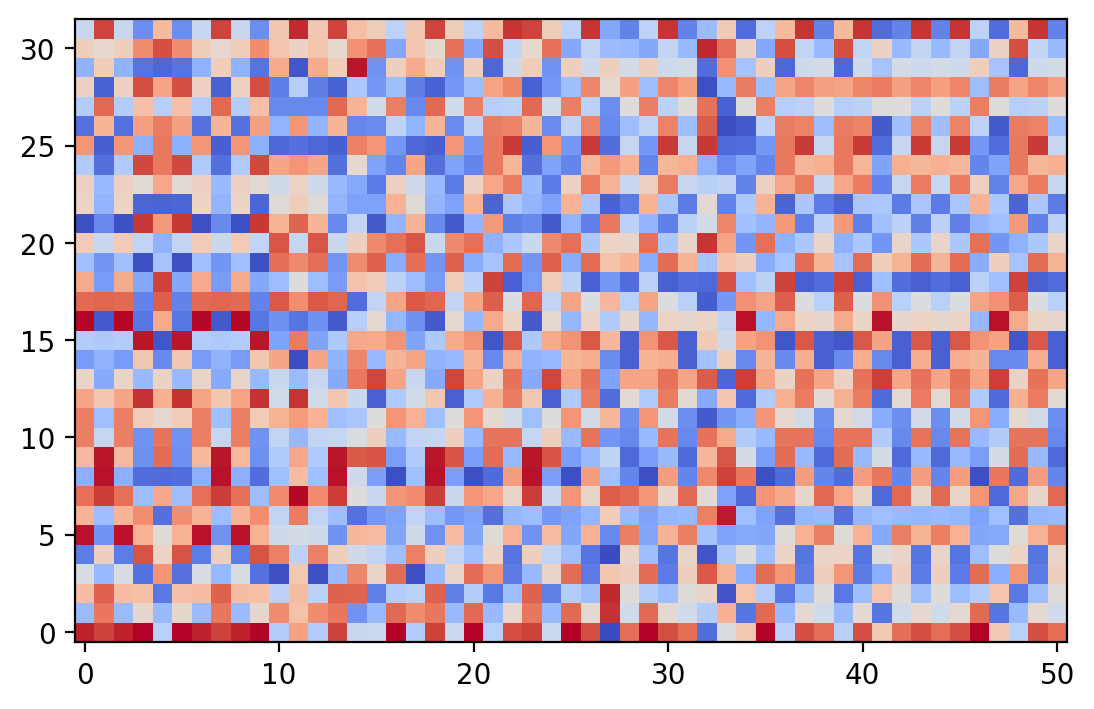

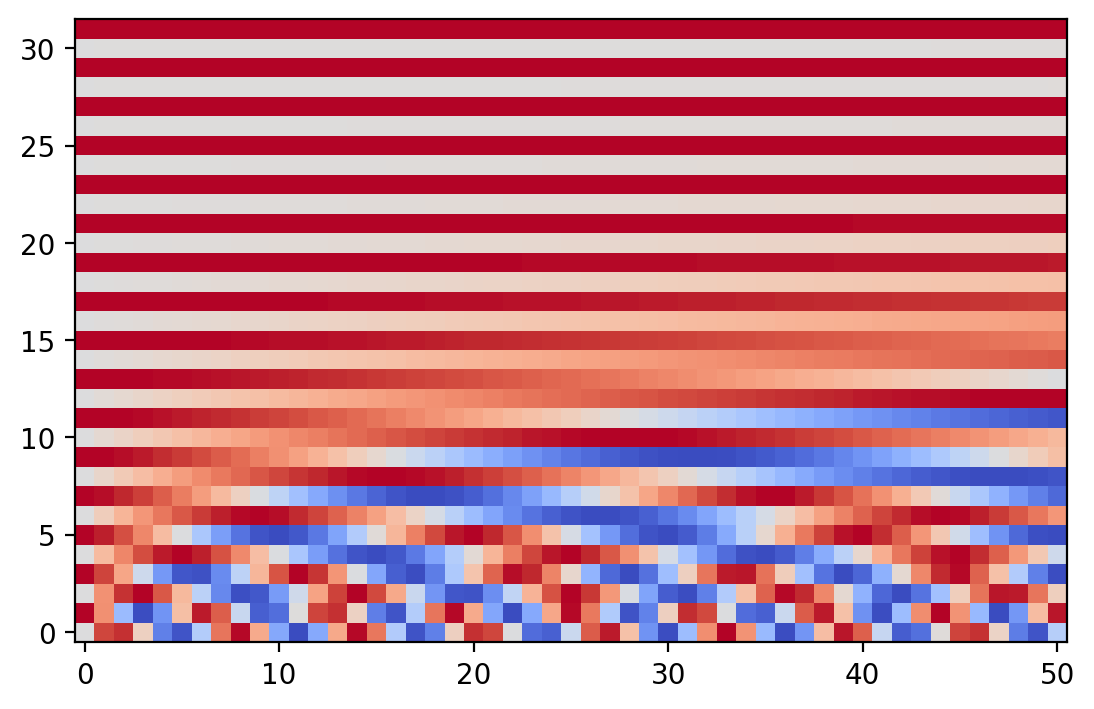

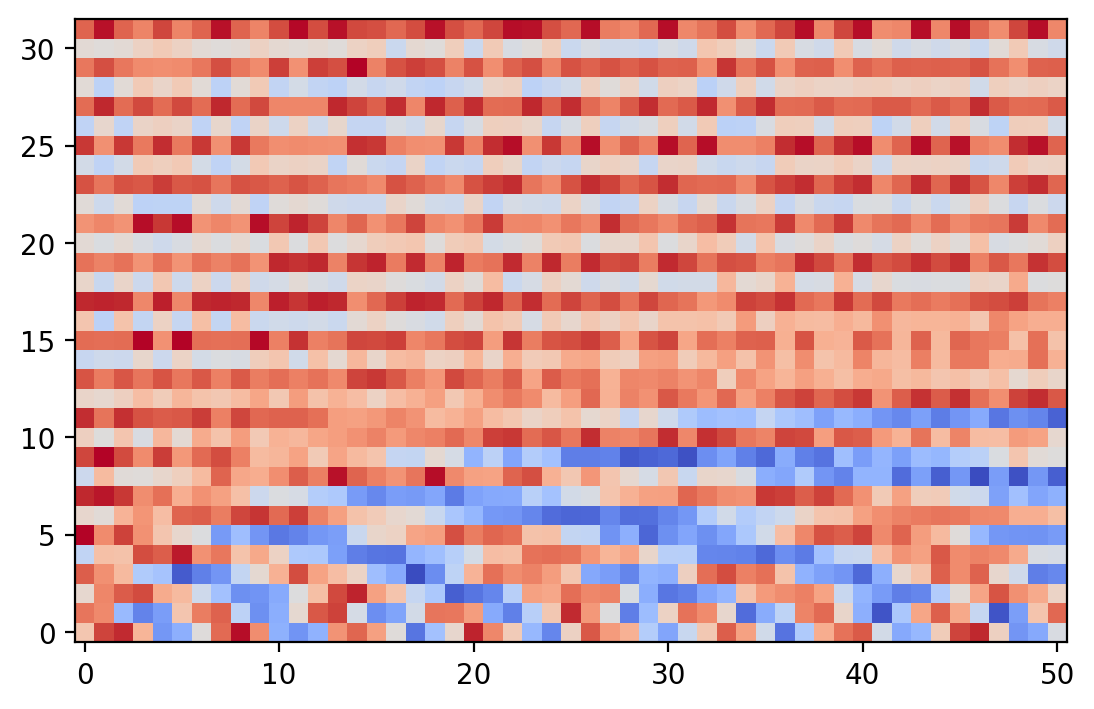

In [18]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

## 8. Build the Transformer model <a name="transformer_decoder"></a>

In [19]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 token_and_position_embedding_1  (None, None, 128)   7552        ['input_1[0][0]']                
  (TokenAndPositionEmbedding)                                                                     
                                                                                                  
 token_and_position_embedding_2  (None, None, 128)   3072        ['input_2[0][0]']            

In [21]:
if LOAD_MODEL:
    model.load_weights("./checkpoint/checkpoint.ckpt")
    # model = models.load_model('./models/model', compile=True)

## 9. Train the Transformer <a name="train"></a>

In [22]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        midi_stream.show()
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "/app/notebooks/11_music/01_transformer/output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [23]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

In [24]:
# Hier loopt het fout
# Uitzoeken waarom?

model.fit(
    ds,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator,
    ],
)

Epoch 1/5000
108/108 [==============================] - ETA: 0s - loss: 4.6096 - note_outputs_loss: 3.4512 - duration_outputs_loss: 1.1584[['START', 'D3', 'G3', 'A2', 'C3', 'G3', 'B2', 'B-3', 'G3', 'G3', 'B-3', 'G3', 'A3', 'G3', 'C4', 'B3', 'B3', 'A3', 'G3', 'G3', 'G3', 'F3', 'D3', 'E3', 'D3', 'G3', 'F3', 'G3', 'B-3', 'G#3', 'B3', 'D3', 'G3', 'D3', 'E-3', 'D3', 'B-2', 'G3', 'G3', 'F3', 'B-3', 'B-3', 'G2', 'G3', 'G3', 'E-3', 'D3', 'D3', 'D3'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


SubConverterFileIOException: /lib/x86_64-linux-gnu/libjack.so.0
/lib/x86_64-linux-gnu/libnss3.so
QEventLoop: Cannot be used without QApplication
QEventLoop: Cannot be used without QApplication
qt.qpa.plugin: Could not find the Qt platform plugin "offscreen" in ""
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb.

/tmp/.mount_MuseScEipqGi/AppRun: line 26: 15359 Aborted                 (core dumped) "${APPDIR}/bin/mscore4portable" "$@"


In [ ]:
# Save the final model
model.save("./models/model")

# 3. Generate music using the Transformer

In [ ]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.5
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()

## Write music to MIDI file

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "/app/notebooks/11_music/01_transformer/output",
        "output-" + timestr + ".mid",
    ),
)

## Note probabilities

In [ ]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

## Attention Plot

In [ ]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [ ]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()